# Progetto Data manipulation e Data visualization

Il progetto si propone di analizzare gli omicidi commessi dalla polizia negli Stati Uniti, concentrandosi sulle sparatorie mortali.

### Obiettivi: 
Analizzare il dataset del Washington Post, contenente le informazioni sugli omicidi a partire dal 2015, su questi fronti: 
- TEMPORALE/CRONOLOGICO: 
esaminare la distribuzione temporale degli omicidi e identificare eventuali tendenze o variazioni nel corso del tempo.
- ETNICO/DEMOGRAFICO:
analizzare le differenze etniche, di età e di genere
- GEOGRAFICO/SPAZIALE:
identificare le aree geografiche negli Stati Uniti con il maggior numero di omicidi e studiare la distribuzione etnica delle vittime.

Calcolare l'incidenza degli omicidi sulla popolazione utilizzando anche il dataset con la popolazione delle città americane.
Nelle conclusioni, integrare le analisi con i dataset socio-economici delle città americane, esplorando quindi le associazioni tra
reddito medio, tasso di povertà e percentuale di istruzione nel contesto degli omicidi.

In [363]:
# importo le librerie necessarie
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.colors as mcolors
from tabulate import tabulate
from colorama import Fore, Style
import plotly.express as px
import folium
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

%matplotlib inline

### PARTE 1. Omicidi nel tempo

In [3]:
# Data Selection
df_fatal = pd.read_csv('fatal-police-shootings-data.csv', encoding='windows-1252')

In [4]:
# Data cleaning 

# Converto la colonna "date" in formato datetime
df_fatal['date'] = pd.to_datetime(df_fatal['date'])

# Elimino le colonne "id", "county", "location_precision", "name" e "race_source"
columns_to_drop = ['id', 'county', 'location_precision', 'name', 'race_source',]
df_fatal = df_fatal.drop(columns=columns_to_drop)

# cambio i nomi degli stati con il loro corrispettivo esteso

# Ottengo i valori unici nella colonna "state"
state_values = df_fatal['state'].unique()

# Dizionario delle sigle degli stati e corrispettivi estesi
state_mapping = {
    'WA': 'Washington','OR': 'Oregon','KS': 'Kansas','CA': 'California','CO': 'Colorado',
    'OK': 'Oklahoma','AZ': 'Arizona','IA': 'Iowa','PA': 'Pennsylvania','TX': 'Texas','OH': 'Ohio',
    'LA': 'Louisiana','MT': 'Montana','UT': 'Utah','AR': 'Arkansas','IL': 'Illinois','NV': 'Nevada',
    'NM': 'New Mexico','MN': 'Minnesota','MO': 'Missouri','VA': 'Virginia','NJ': 'New Jersey',
    'IN': 'Indiana','KY': 'Kentucky','MA': 'Massachusetts','NH': 'New Hampshire','FL': 'Florida',
    'ID': 'Idaho','MD': 'Maryland','NE': 'Nebraska','MI': 'Michigan','GA': 'Georgia','TN': 'Tennessee',
    'NC': 'North Carolina','AK': 'Alaska','NY': 'New York','ME': 'Maine','AL': 'Alabama',
    'MS': 'Mississippi','WI': 'Wisconsin','SC': 'South Carolina','DE': 'Delaware',
    'DC': 'District of Columbia','WV': 'West Virginia','HI': 'Hawaii','WY': 'Wyoming',
    'ND': 'North Dakota','CT': 'Connecticut','SD': 'South Dakota','VT': 'Vermont','RI': 'Rhode Island'
}

# Trasformo "B;H" in "O" in race
df_fatal['race'] = df_fatal['race'].replace('B;H', 'O')

# Dizionario delle sigle delle razze e corrispettivi estesi
race_mapping = {
    'W': 'White',
    'B': 'Black',
    'H': 'Hispanic',
    'A': 'Asian',
    'N': 'Native American',
    'O': 'Other'
}

# Applico la mappatura alle sigle degli stati nel dataframe
df_fatal['state'] = df_fatal['state'].map(state_mapping)

# Applico la mappatura alle sigle delle razze nel dataframe
df_fatal['race'] = df_fatal['race'].map(race_mapping)

# assegno undetermined ai valori nulli nella colonna race
df_fatal['race'] = df_fatal['race'].fillna('Undetermined')


# Mappa i valori della colonna 'armed_with' in base alle condizioni specificate
mapping = {
    'unarmed': 'unarmed',
    'undetermined': 'undetermined'
}
df_fatal['armed_with'] = df_fatal['armed_with'].replace(mapping)

# Rimpiazza tutti i valori diversi da 'unarmed', 'undetermined' e NaN con 'armed'
df_fatal.loc[~df_fatal['armed_with'].isin(['unarmed', 'undetermined', np.nan]), 'armed_with'] = 'armed'


In [7]:
# Data exploration

# calcolo la data minima e massima nel dataframe (più vecchia e più recente)
min_date = df_fatal['date'].min()
max_date = df_fatal['date'].max()

# calcolo il conteggio totale degli omicidi registrati
total_kill = len(df_fatal)

# divido gli omicidi per anno 

# estraggo l'anno dalla colonna 'date' e calcolo il conteggio per ogni anno
kill_by_year = df_fatal['date'].dt.year.value_counts().sort_index()

# calcolo la percentuale per ogni anno
percentages = kill_by_year / total_kill * 100

# stampo
print(f'Data inizio: {min_date}\nData fine: {max_date}\n')
print(f'Totale omicidi registrati: {total_kill}\n')

# Trova l'anno con il conteggio maggiore
anno_max = kill_by_year.idxmax()

# Prepara i dati per la tabella
table_data = []
for year, count in kill_by_year.items():
    percentage = percentages[year]
    if year == anno_max:
        table_data.append([Fore.RED + str(year), count, f'{percentage:.2f}%' + Style.RESET_ALL])
    else:
        table_data.append([year, count, f'{percentage:.2f}%'])

# Stampa la tabella
headers = ['Anno', 'Conteggio', 'Percentuale']
print(tabulate(table_data, headers, tablefmt='fancy_grid'))

Data inizio: 2015-01-02 00:00:00
Data fine: 2023-06-01 00:00:00

Totale omicidi registrati: 8520

╒════════╤═════════════╤═══════════════╕
│   Anno │   Conteggio │ Percentuale   │
╞════════╪═════════════╪═══════════════╡
│   2015 │         995 │ 11.68%        │
├────────┼─────────────┼───────────────┤
│   2016 │         958 │ 11.24%        │
├────────┼─────────────┼───────────────┤
│   2017 │         983 │ 11.54%        │
├────────┼─────────────┼───────────────┤
│   2018 │         992 │ 11.64%        │
├────────┼─────────────┼───────────────┤
│   2019 │         997 │ 11.70%        │
├────────┼─────────────┼───────────────┤
│   2020 │        1019 │ 11.96%        │
├────────┼─────────────┼───────────────┤
│   2021 │        1048 │ 12.30%        │
├────────┼─────────────┼───────────────┤
│   2022 │        1096 │ 12.86%        │
├────────┼─────────────┼───────────────┤
│   2023 │         432 │ 5.07%         │
╘════════╧═════════════╧═══════════════╛


- Scopriamo quindi che i dati si riferiscono al periodo dal 2 gennaio 2015 al 1 giugno 2023.
- Il totale degli omicidi da parte della polizia negli Stati Uniti in questo lasso di tempo è di 8520 persone.
- La tabella mostra il conteggio degli omicidi per ogni anno, insieme alla percentuale che rappresenta rispetto al totale. In rosso faccio risaltare l'anno con il numero più alto di omicidi, che risulta essere il 2022 che con 1096 vittime rappresenta il 12.86% del totale delle vittime di questo dataset

In [20]:
# Data transformation

# Creazione del nuovo dataframe
df_kill_by_year = pd.DataFrame({
    'year': kill_by_year.index,
    'total_count': kill_by_year.values,
    'percent': percentages.values.round(2)
})

# escludo il 2023 dalle visualizzazioni
df_kill_by_year_filtered = df_kill_by_year[df_kill_by_year['year'] != 2023]

# calcolo la media annuale
average_kill_by_year = df_kill_by_year_filtered['total_count'].mean()

# estraggo l'anno e il mese dalla colonna 'date'
df_fatal['year'] = df_fatal['date'].dt.year
df_fatal['month'] = df_fatal['date'].dt.month

# calcolo il conteggio degli omicidi per ogni combinazione di anno e mese
total_kill_by_year_month = df_fatal.groupby(['year', 'month']).size().reset_index(name='count')

# creo un altro DataFrame con anni e mesi come colonne
df_kill_by_year_month = pd.pivot_table(total_kill_by_year_month, values='count', index='year', columns='month')

# filtro fino al 2022 - escludo il 2023
df_kill_by_year_month = df_kill_by_year_month[df_kill_by_year_month.index != 2023]

# conversione in interi
df_kill_by_year_month = df_kill_by_year_month.astype(int)

# raggruppo i dati per anno e razza e ne faccio un conteggio
race_count = df_fatal.groupby(['year', 'race']).size().reset_index(name='count')

# collego il dataframe con quello del conteggio annuale
df_race_merged = race_count.merge(df_kill_by_year, on='year')

# escludo il 2023 
df_race_merged_filtered = df_race_merged[df_race_merged['year'] != 2023]

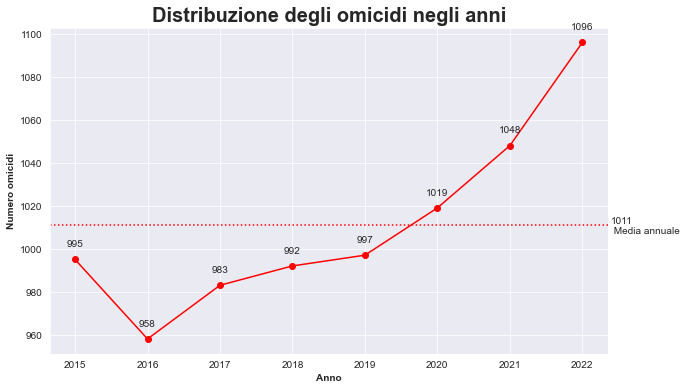

In [364]:
# Data visualization

# imposto stile seaborn 
sns.set_style('darkgrid')

# creazione del grafico a linee
plt.figure(figsize=(10,6))
plt.plot(df_kill_by_year_filtered['year'], df_kill_by_year_filtered['total_count'], marker='o', linestyle='-', color='red', markersize=6)

# aggiunta della linea tratteggiata per la media annuale
plt.axhline(y=average_kill_by_year, color='red', linestyle=':', label='Media annuale')

# aggiunta dell'etichetta della media annuale
plt.text(df_kill_by_year_filtered['year'].iloc[-1] + 0.4, average_kill_by_year+4, f'{int(average_kill_by_year)}\n Media annuale', ha='left', va='top')

# aggiunta delle etichette ad ogni punto
for i, j in zip(df_kill_by_year_filtered['year'], df_kill_by_year_filtered['total_count']):
    plt.text(i, j+5, str(j), ha='center', va='bottom')

# titoli degli assi e del grafico
plt.xlabel('Anno', fontweight='bold')
plt.ylabel('Numero omicidi', fontweight='bold')
plt.title('Distribuzione degli omicidi negli anni', fontsize=20,fontweight='bold')

# visualizzazione del grafico
plt.show()


Con questo grafico vediamo chiaramente che dal 2016 c'è una costante tendenza all'aumento del numero degli omicidi da parte edlla polizia, con il numero più alto registrato nel 2022, addirittura 1096. La media annuale dei morti è 1011, l'anno con il numero più basso sarebbe ovviamente il 2023, essendo ancora in corso; escludendolo quindi dall'analisi, il 2016 è l'anno che registra meno morti, 958.

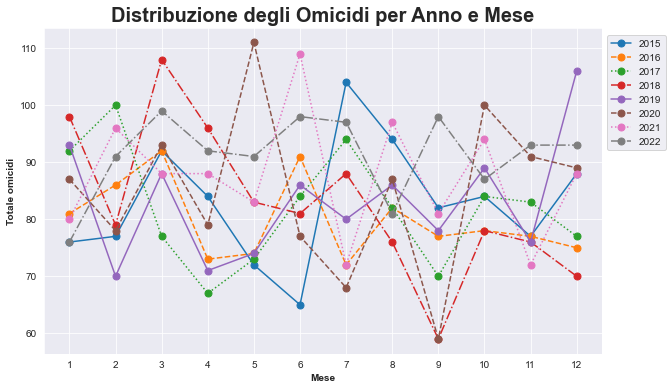

In [365]:
# Creo grafico a linee
plt.figure(figsize=(10,6))

linestyles = ['solid', 'dashed', 'dotted', 'dashdot']  # Lista degli stili di linea desiderati
for i, year in enumerate(df_kill_by_year_month.index):
    linestyle = linestyles[i % len(linestyles)]  # Seleziona lo stile di linea dalla lista in base all'indice
    plt.plot(df_kill_by_year_month.loc[year], marker='o', linestyle=linestyle, markersize=7, label=str(year))

# Personalizzazione degli assi e del titolo
plt.xlabel('Mese', fontweight='bold')
plt.ylabel('Totale omicidi', fontweight='bold')
plt.title('Distribuzione degli Omicidi per Anno e Mese', fontsize=20, fontweight='bold')

# Imposta i ticks per ogni mese da 1 a 12
plt.xticks(range(1, 13)) 

# Mostra la legenda
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))

# Mostra il grafico
plt.show()

Il grafico rappresenta la distribuzione degli omicidi per anno e mese nel periodo considerato. Ogni linea nel grafico rappresenta un anno diverso, e l'asse x rappresenta i mesi.

Osservando il grafico, possiamo notare come la distribuzione degli omicidi può variare nel corso degli anni. Alcuni anni mostrano picchi di omicidi in determinati mesi, mentre altri presentano una distribuzione più uniforme nel corso dell'anno.

Complessivamente, il grafico permette di visualizzare la variazione mensile degli omicidi nel corso degli anni considerati, fornendo un'idea della stagionalità o delle tendenze periodiche degli omicidi.

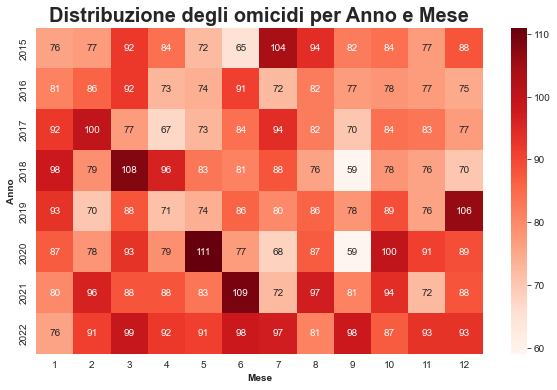

In [366]:
# creazione del grafico a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_kill_by_year_month, cmap='Reds', annot=True, fmt='d')

# assi e titolo
plt.xlabel('Mese', fontweight='bold')
plt.ylabel('Anno', fontweight='bold')
plt.title('Distribuzione degli omicidi per Anno e Mese', fontsize=20, fontweight='bold')

# visualizzo il grafico
plt.show()

Questa heatmap rappresenta la distribuzione degli omicidi per anno e mese nel periodo considerato. I toni più scuri delle caselle indicano un numero maggiore di omicidi, mentre i toni più chiari indicano un numero inferiore. Le etichette sull'asse x rappresentano i mesi, mentre sull'asse y rappresentano gli anni. Le cifre rappresentano il numero esatto di omicidi registrati in quel mese di quell'anno. Ho abilitato l'annotazione dei valori per fornire una visualizzazione più precisa dei dati. Questo grafico consente di identificare i periodi in cui si sono verificati un numero maggiore o inferiore di omicidi nei mesi nel corso degli anni considerati. Ci accorgiamo subito che alcuni mesi sono 'molto scuri' come maggio 2020, record con 111 omicidi mensili, giugno 2021, ma anche dicembre 2019 e marzo 2018. I record 'positivi' sono invece sempre a settembre, 2018 e 2020, con lo stesso numero di vittime, 59.

In [16]:
# Calcolo la media mensile
media_mensile = df_kill_by_year_month.mean()

# Trova la media mensile più alta e più bassa
max_media = media_mensile.max()
min_media = media_mensile.min()

print('Media di vittime in ogni mese:')
# Stampa la media mensile
for mese, media in media_mensile.items():
    if media == max_media:
        print(f'\033[91m{mese}: {media:.1f}\033[0m')  # Stampa in rosso la media più alta
    elif media == min_media:
        print(f'\033[92m{mese}: {media:.1f}\033[0m')  # Stampa in verde la media più bassa
    else:
        print(f'{mese}: {media:.1f}') 


Media di vittime in ogni mese:
1: 85.4
2: 84.6
3: 92.1
4: 81.2
5: 82.6
6: 86.4
7: 84.4
8: 85.6
9: 75.5
10: 86.8
11: 80.6
12: 85.8


Questo output rappresenta il conteggio della media di ogni mese. Ho evidenziato con i colori rosso e verde le media più alte e basse. Così riusciamo immediatamente a riconoscere marzo come il mese con la media morti più alta, oltre 92, mentre a settembre troviamo quella più bassa, 75.5.

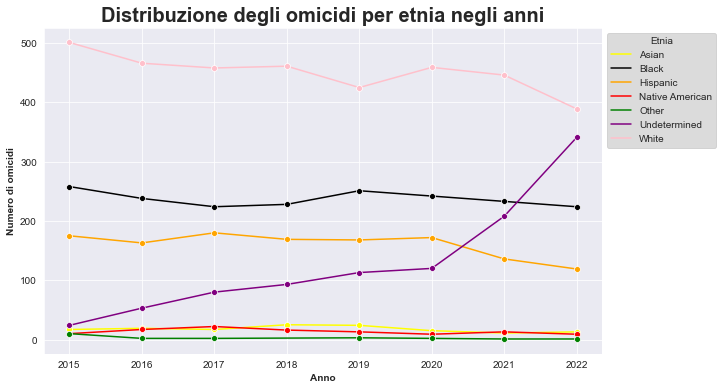

In [367]:
# faccio il grafico
plt.figure(figsize=(10, 6))
custom_palette = ['yellow', 'black', 'orange', 'red', 'green', 'purple', 'pink']
sns.lineplot(data=df_race_merged_filtered, x='year', y='count', hue='race', marker='o',
            palette=custom_palette)

# titolo, legenda, assi
plt.title('Distribuzione degli omicidi per etnia negli anni', fontsize=20, fontweight='bold')
plt.legend(title='Etnia', loc='upper left', facecolor='lightgrey', bbox_to_anchor=(1, 1))
plt.xlabel('Anno', fontweight='bold')
plt.ylabel('Numero di omicidi', fontweight='bold')

# visualizzo il grafico
plt.show()

Questo grafico rappresenta la distribuzione degli omicidi per etnia nel corso del tempo. L'andamento è abbastanza lineare per alcune etnie; in generale, per l'etnia White, Black e Hispanic,le più colpite, sembra esserci una leggera tendenza ad una diminuzione dei casi nel tempo. Ma non si spiegherebbe il grafico precedente, in cui l'andamento complessivo nel tempo, dal 2016, sembrava in costante aumento. Fortunatamente ci viene in soccorso per comprendere meglio i dati l'etnia che ho aggiunto, 'undetermined', la cui tendenza ci palesa il perchè i dati complessivi siano in aumento, mentre quelli delle 3 maggiori etnie colpite, in diminuzione. Soprattutto dal 2020, il numero di vittime di cui non si ha informazione sulla razza sono in aumento, vertiginoso; questo può essere dovuto ad una molteplicità di fattori, il cui studio esula però dagli obiettivi di questa analisi. Il grafico qua sotto rafforza le idee qua espresse.

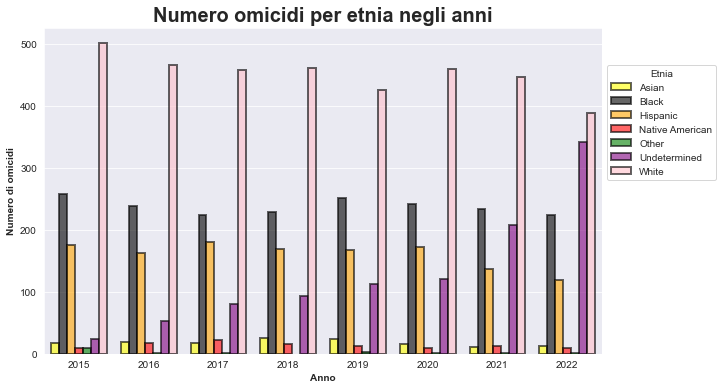

In [369]:
# Creo il grafico a barre 
plt.figure(figsize=(10, 6))

sns.barplot(data=df_race_merged_filtered, x='year', y='count', hue='race', 
            palette=custom_palette, 
            edgecolor='black', 
            linewidth=2, 
            saturation=1, 
            alpha=0.6)

# Titolo, legenda, assi
plt.title('Numero omicidi per etnia negli anni', fontsize=20, fontweight='bold')
plt.legend(title='Etnia', loc='upper left', facecolor='white', bbox_to_anchor=(1, 0.9))
plt.xlabel('Anno', fontweight='bold')
plt.ylabel('Numero di omicidi', fontweight='bold')

# Visualizzo il grafico
plt.show()

Con questo grafico riusciamo a vedere le informazioni adatte per confrontare il numero di vittime di ogni etnia in ogni anno e conferma i dati analizzati finora.

In [39]:
# Calcolo il numero totale di omicidi per ogni anno
total_deaths_per_year = df_race_merged_filtered.groupby('year')['count'].sum()

# Calcolo il numero di omicidi per ogni etnia in ogni anno
deaths_by_race_per_year = df_race_merged_filtered.groupby(['year', 'race'])['count'].sum().unstack()

# Calcolo la percentuale di omicidi per ogni etnia in ogni anno
percentages_by_race_per_year = deaths_by_race_per_year.divide(total_deaths_per_year, axis=0) * 100

# Stampo i dati per ogni anno
for year in deaths_by_race_per_year.index:
    print(f"Anno: {year}")
    year_total_deaths = total_deaths_per_year[year]
    print(f"Vittime totali: {year_total_deaths}")

    # Assegno 0 a "Other" se il conteggio è NaN
    if np.isnan(deaths_by_race_per_year.loc[year, 'Other']):
        deaths_by_race_per_year.loc[year, 'Other'] = 0
        percentages_by_race_per_year.loc[year, 'Other'] = 0.0

    # Trovo la riga con il valore massimo e il valore minimo
    max_row = deaths_by_race_per_year.loc[year].idxmax()
    min_row = deaths_by_race_per_year.loc[year].idxmin()

    for race in deaths_by_race_per_year.columns:
        count = deaths_by_race_per_year.loc[year, race]
        percentage = percentages_by_race_per_year.loc[year, race]

        # Evidenzio la riga con il valore massimo in rosso
        if race == max_row:
            print(f"\033[1;31m{race}: {count} ({percentage:.1f}%)\033[0m")
        # Evidenzio la riga con il valore minimo in verde
        elif race == min_row:
            print(f"\033[1;32m{race}: {count} ({percentage:.1f}%)\033[0m")
        else:
            print(f"{race}: {count} ({percentage:.1f}%)")

    print()


Anno: 2015
Vittime totali: 995
Asian: 17.0 (1.7%)
Black: 258.0 (25.9%)
Hispanic: 175.0 (17.6%)
Native American: 10.0 (1.0%)
Other: 10.0 (1.0%)
Undetermined: 24.0 (2.4%)
White: 501.0 (50.4%)

Anno: 2016
Vittime totali: 958
Asian: 19.0 (2.0%)
Black: 238.0 (24.8%)
Hispanic: 163.0 (17.0%)
Native American: 17.0 (1.8%)
Other: 2.0 (0.2%)
Undetermined: 53.0 (5.5%)
White: 466.0 (48.6%)

Anno: 2017
Vittime totali: 983
Asian: 17.0 (1.7%)
Black: 224.0 (22.8%)
Hispanic: 180.0 (18.3%)
Native American: 22.0 (2.2%)
Other: 2.0 (0.2%)
Undetermined: 80.0 (8.1%)
White: 458.0 (46.6%)

Anno: 2018
Vittime totali: 992
Asian: 25.0 (2.5%)
Black: 228.0 (23.0%)
Hispanic: 169.0 (17.0%)
Native American: 16.0 (1.6%)
Other: 0.0 (0.0%)
Undetermined: 93.0 (9.4%)
White: 461.0 (46.5%)

Anno: 2019
Vittime totali: 997
Asian: 24.0 (2.4%)
Black: 251.0 (25.2%)
Hispanic: 168.0 (16.9%)
Native American: 13.0 (1.3%)
Other: 3.0 (0.3%)
Undetermined: 113.0 (11.3%)
White: 425.0 (42.6%)

Anno: 2020
Vittime totali: 1019
Asian: 15.0 (1.

Questo output esplica ancora più nel dettaglio il grafico precedente, stampando per ogni anno, conteggio totale delle vittime, e composizione etnica percentuale. Uno dei trend osservabili è sottolineato dal colore rosso, che va a sottolineare l'etnia più colpita in quel determinato anno, ed è sempre la White. In verde troviamo sottolineata l'informazione opposta, ovvero l'etnia meno colpita, che in molti casi è Other. Le percentuali più basse sembrano spettare quasi sempre a Asian e Native American.

### PARTE 2. Analisi età, genere ed etnia

In [40]:
# Data exploration

# Calcolo il numero di vittime senza informazioni sull'età
vittime_senza_eta = df_fatal['age'].isna().sum()

# Calcolo la percentuale relativa a total_kill
percentuale_senza_eta = (vittime_senza_eta / total_kill) * 100

# Stampo i risultati
print(f"Numero di vittime senza informazioni sull'età: {vittime_senza_eta} - {percentuale_senza_eta:.2f}%")

Numero di vittime senza informazioni sull'età: 572 - 6.71%


In [41]:
# age stats
df_fatal['age'].describe().round(2)

count    7948.00
mean       37.31
std        13.00
min         2.00
25%        27.00
50%        35.00
75%        46.00
max        92.00
Name: age, dtype: float64

Scoprendo che il 6.71% delle vittime non ha informazioni sull'età, e volendo esplorare proprio la distribuzione di qeust'ultima, in questo caso il conteggio che si delinea è di 7948 vittime. L'età media è di 37 anni, la vittima più giovane ne aveva appena 2, e la più anziana 92.

In [44]:
# escludo il valore non-binary essendo solo 1
gender_count = df_fatal[df_fatal['gender'] != 'non-binary']

# stats per genere
gender_count.groupby('gender')['age'].describe().round(2)

count   mean    std  min   25%   50%   75%   max
gender                                                   
female   355.0  37.45  13.04  2.0  28.0  36.0  46.0  91.0
male    7583.0  37.31  13.00  6.0  27.0  35.0  45.0  92.0

In [47]:
# Calcolo la percentuale rispetto al totale
gender_counts = gender_count['gender'].value_counts()
total_count = gender_counts.sum()
gender_percentages = gender_counts / total_count * 100

# Formatto le percentuali come stringhe con il simbolo '%'
formatted_percentages = gender_percentages.map('{:.2f}%'.format)
formatted_percentages

male      95.59%
female     4.41%
Name: gender, dtype: object

Le età medie sono simili così come quelle massime. C'è una differenza nelle età minime, dove quelle femminile segna 2 anni, e maschile 6.  Più del 95% delle vittime di cui sappiamo l'età  sono vittime di sesso maschile; il sesso femminile rappresenta solo il 4.41% dei casi.

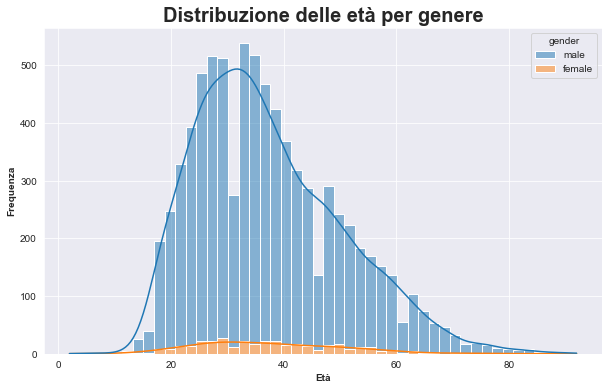

In [372]:
# creo histplot
plt.figure(figsize=(10, 6))
sns.histplot(data=gender_count, x='age', hue='gender', kde=True, multiple='stack')


plt.xlabel('Età', fontweight='bold')
plt.ylabel('Frequenza', fontweight='bold')
plt.title('Distribuzione delle età per genere', fontsize=20, fontweight='bold')

plt.show()

Con questo istogramma studiamo la distribuzione delle età per genere. Come ci aspettiamo di trovare, vediamo che il grafico ha colonne molto alte per il genere maschile, e soprattutto nella fascia d'età 20-40, come sembra suggerire anche la linea blu che segue la distribuzione e che trova il suo picco proprio lì.

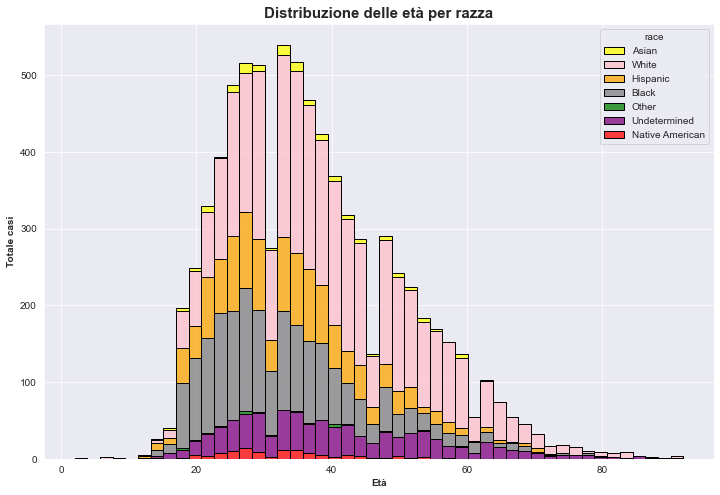

In [373]:
# creao histplot per età e razza
plt.figure(figsize=(12, 8))
race_palette = ['yellow', 'pink', 'orange', 'grey', 'green', 'purple', 'red']
sns.histplot(data=df_fatal, x='age', hue='race', multiple='stack', palette=race_palette, edgecolor='black')

plt.title('Distribuzione delle età per razza', fontsize=15, fontweight='bold')
plt.xlabel('Età', fontweight='bold')
plt.ylabel('Totale casi', fontweight='bold')

plt.show()

Questo grafico prende in considerazione le età e le razze. Come si puà notare le barre sono impilate, mostrando la quantità effettiva che rappresenta quella razza in quella precisa fascia d'età, usando colori differenti come esplicitato nella legenda. Si riescono a notare alcuni trend, come il range d'età coperto dai Native American ad esempio, che risulta essere più corto rispetto alle altre etnie. In generale si può anche notare, tra le altre cose, che nelle fasce d'età molto giovani sono presenti in modo significativo i colori rappresentanti soprattutto le etnie Hispanic e Black.

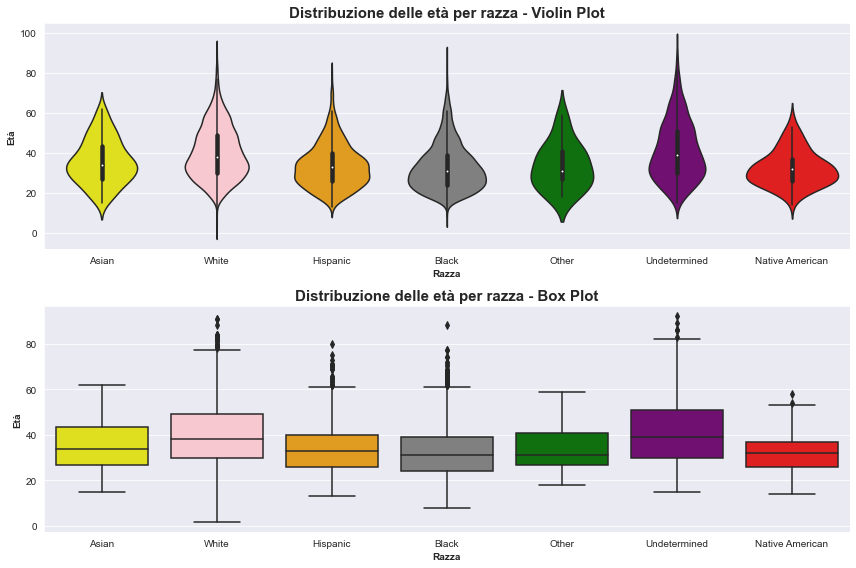

In [142]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.violinplot(data=df_fatal, x='race', y='age', palette=race_palette)
plt.title('Distribuzione delle età per razza - Violin Plot', fontsize=15, fontweight='bold')
plt.xlabel('Razza', fontweight='bold')
plt.ylabel('Età', fontweight='bold')

plt.subplot(2, 1, 2)
sns.boxplot(data=df_fatal, x='race', y='age', palette=race_palette)
plt.title('Distribuzione delle età per razza - Box Plot', fontsize=15, fontweight='bold')
plt.xlabel('Razza', fontweight='bold')
plt.ylabel('Età', fontweight='bold')

plt.tight_layout()
plt.show()


In [136]:
# stats 
age_race = df_fatal.groupby("race")["age"].agg(["count", "min", "max", "mean"]).round(2)
age_race

count   min   max   mean
race                                     
Asian              140  15.0  62.0  35.72
Black             1907   8.0  88.0  32.94
Hispanic          1265  13.0  80.0  33.71
Native American    109  14.0  58.0  32.39
Other               21  18.0  59.0  33.52
Undetermined       862  15.0  92.0  41.05
White             3644   2.0  91.0  40.19

I grafici boxplot e violinplot, insieme con  questo output ci danno un idea sommaria prima e dettagliata poi della distribuzione delle età delle vittime, dividendole per razza. La media delle età è tutto sommato abbastanza variabile, con la media più basse che spetta ai Native American(32.3) seguiti dai Black(32.9), la più alta invece a Undetermined(41) e White(40). Per ogni etnia abbiamo quindi il conteggio totale, l'età minima, massima, e la media delle età.

In [58]:
# conteggio e percentuale per razza
race_count = df_fatal['race'].value_counts()
race_percentage = race_count / total_count * 100

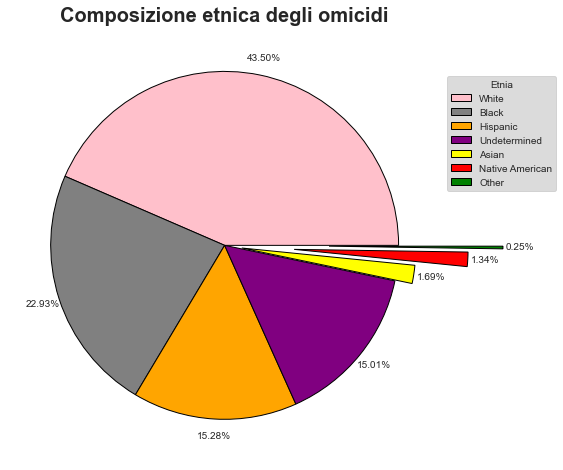

In [59]:
# Crea una lista di colori mappati alle etnie desiderate
ethnicity_colors = {'White': 'pink', 'Black': 'grey', 'Hispanic': 'orange', 'Asian': 'yellow', 'Native American': 'red', 'Other': 'green', 'Undetermined': 'purple'}
sorted_palette = [ethnicity_colors[ethnicity] for ethnicity in race_percentage.index]

# Crea una lista di esplosioni per le ultime tre fette
explode = [0] * (len(race_count) - 3) + [0.1, 0.4, 0.6]

# Crea il grafico a torta
plt.figure(figsize=(8, 8))
wedges, _, _ = plt.pie(race_percentage, labels=[''] * len(race_percentage), autopct='%.2f%%', colors=sorted_palette, explode=explode, wedgeprops={'edgecolor': 'black'}, pctdistance=1.1)

# Rimuovi etichetta dell'asse y
plt.ylabel('')

# Aggiungi la legenda con i colori delle etnie
plt.legend(wedges, race_percentage.index, loc='upper left', bbox_to_anchor=(1, 0.9), title='Etnia', facecolor='lightgrey')

# Titolo del grafico
plt.title('Composizione etnica degli omicidi', fontsize=20, fontweight='bold')

# Visualizza il grafico
plt.show()

Questo grafico a torta rappresenta la composizione etnica degli omicidi negli Stati Uniti nel periodo preso in considerazione. E' interessante notare che ci sono alcune etnie che presentano la maggior parte delle vittime, come l'etnia 'White'(43%) che da sola conta quasi la metà delle vittime totali, . Quasi il 23% sono di etnia 'Black' e quasi il 16% Hispanic. Le restanti etnie rappresentano una percentuale molto piccola, Asian 1.69% e Native American 1.34%. Abbiamo poi una 'fetta' della torta di colore viola, che rappresenta le vittime di cui non si hanno informazioni sulla razza, ovvero il 15%.

<Figure size 720x432 with 0 Axes>

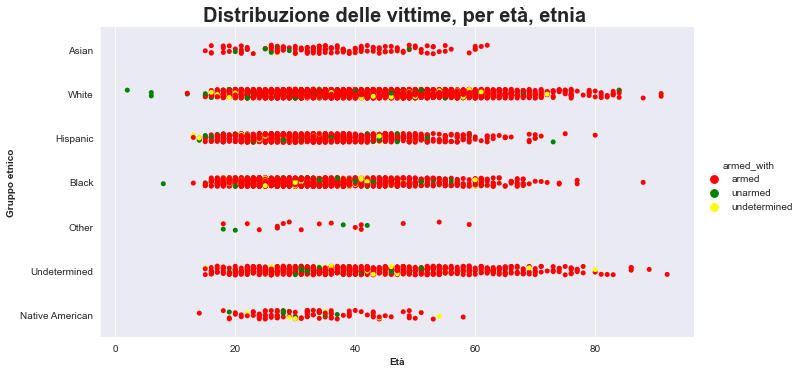

In [52]:
# creo catplot
plt.figure(figsize=(10, 6))
custom_palette = {'armed': 'red', 'unarmed': 'green', 'undetermined': 'yellow'}

sns.catplot(data=gender_count, y='race', x='age', hue='armed_with', palette=custom_palette, height=5, aspect=2)

plt.title('Distribuzione delle vittime, per età, etnia ', fontsize=20, fontweight='bold')
plt.xlabel('Età', fontweight='bold')
plt.ylabel('Gruppo etnico', fontweight='bold')


plt.show()

Questo grafico catplot mette in relazione l'eta delle vittime, raggruppate per gruppo etnico, segnalate con una colorazione diversa, che rispecchia se erano armati o no. Si vede chiaramente che nella stragrande maggioranza dei casi le vittime erano armate. Inoltre vediamo che i 'range' di distribuzione dell'età all'interno dei singoli gruppi etnici possono variare e variano anche di molto. Possiamo osservare che quasi tutte le etnie iniziano la loro distribuzione un pò prima dei 20 anni, ma il range di Asiatici e Nativi Americani si arresta intorno ai 60 anni. Negli altri gruppi il range si estende oltre gli 80 e anche 90 anni, soprattuto tra i White e Undetermined.

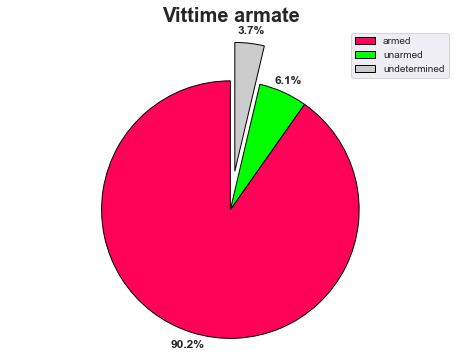

In [61]:
value_counts = df_fatal['armed_with'].value_counts(dropna=True)

# Calcola le percentuali sul totale
percentages = value_counts / value_counts.sum() * 100

# Prepara i dati per il grafico
sizes = percentages.values
# Etichette delle fette
labels = percentages.index

# Colori personalizzati
colors = ['#FF0359', '#00FF00', '#CCCCCC']

# Esplosione della fetta "undetermined"
explode = (0, 0, 0.3)

# Crea il grafico a torta
plt.figure(figsize=(8, 6))
patches, texts, autotexts = plt.pie(sizes,autopct='%1.1f%%', startangle=90,colors=colors, explode=explode, 
                                    wedgeprops={'edgecolor': 'black'}, pctdistance=1.1)
plt.setp(autotexts, size=12, weight="bold")
plt.axis('equal')
plt.title('Vittime armate', fontsize=20, fontweight='bold')

# Aggiungi legenda in alto a destra
plt.legend(labels, loc='upper right')

# Aggiungi cornice nera a ogni fetta
for patch in patches:
    patch.set_edgecolor('black')

# Mostra il grafico
plt.show()

Notiamo quindi che la percentuale di vittime armate è spaventosa: più del 90% delle persone decedute era armato. Il 3.7% rappresenta la percentuale di persone di cui non è stato determinato il possesso di un'arma al momento dell'incidente fatale. Solamente il 6% delle vittime è quindi risultata essere disarmata. Temo che sia proprio questo dato qui che più di tutti spiega un numero così alto di omicidi da parte della polizia in America. Il possesso delle armi, soprattutto da fuoco, è un problema sempre più pressante in questa zona del mondo.

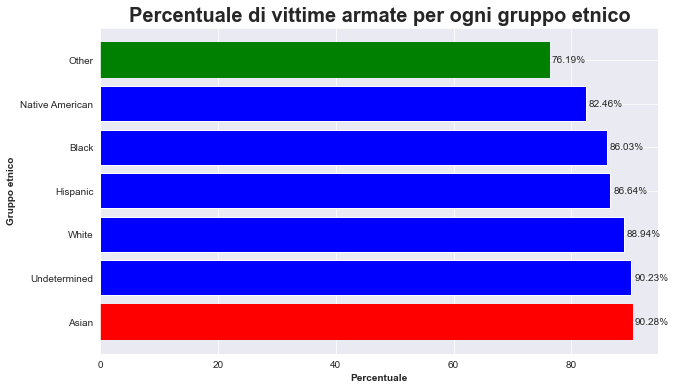

In [54]:
# Calcola la percentuale di casi "armed" per ogni gruppo etnico
ethnicity_percentage = (df_fatal[df_fatal['armed_with'] == 'armed'].groupby('race').size() / df_fatal.groupby('race').size()) * 100

# Ordina i risultati in ordine decrescente
ethnicity_percentage = ethnicity_percentage.sort_values(ascending=False)

# Crea il grafico a barre orizzontali
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(ethnicity_percentage.index, ethnicity_percentage, color='blue')

# Colora la barra più lunga di rosso e quella più corta di verde
longest_bar = ethnicity_percentage.idxmax()
shortest_bar = ethnicity_percentage.idxmin()
bars[ethnicity_percentage.index.tolist().index(longest_bar)].set_color('red')
bars[ethnicity_percentage.index.tolist().index(shortest_bar)].set_color('green')

# Aggiungi le percentuali di armati accanto a ciascuna barra
for i, bar in enumerate(bars):
    percentage = f'{ethnicity_percentage.iloc[i]:.2f}%'
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, percentage,
            ha='left', va='center')

# Imposta il titolo e le etichette degli assi
plt.title('Percentuale di vittime armate per ogni gruppo etnico', fontsize=20, fontweight='bold')
plt.xlabel('Percentuale', fontweight='bold')
plt.ylabel('Gruppo etnico', fontweight='bold')

# Visualizza il grafico
plt.show()

Questo grafico aiuta a determinare l'etnia che conta la percentuale più alta di vittime armate al momento del decesso, che è quella Asiatica con oltre il 90% dei casi. Se escludiamo Other con il 76, l'etnia con la più bassa percentuale di vittime armate è Native American, comunque con un numero altissimo, oltre 82%.

### PARTE 3. Analisi geografica

In [62]:
# Data selection

# per questa sezione utilizzerò anche il dataset della popolazione americana
# carico il dataset
df_population = pd.read_csv('PopulationByCity.csv', encoding='windows-1252')

In [374]:
# Data cleaning
# rimpiazzo gli stati con il loro corrispettivo esteso
df_population['state'] = df_population['state'].map(state_mapping)

# Data exploration/transformation
# conteggio per stato
state_count = df_fatal['state'].value_counts()

# creo nuovo DataFrame con il conteggio totale per ogni stato
df_state = pd.DataFrame({'state': state_count.index, 'count': state_count.values})

# aggiungo una colonna percent
df_state['percent'] = ((df_state['count'] / total_kill) * 100).round(2)

df_state.head(10)

state  count  percent
0      California   1208    14.18
1           Texas    784     9.20
2         Florida    544     6.38
3         Arizona    387     4.54
4         Georgia    323     3.79
5        Colorado    311     3.65
6  North Carolina    244     2.86
7            Ohio    241     2.83
8       Tennessee    236     2.77
9        Oklahoma    236     2.77

Nell'output ci sono i 10 stati 'peggiori'. Ho creato questo dataframe contenente dati suddivisi per stato; il totale delle vittime e la percentuale che rappresenta rispetto al totale delle vittime della polizia negli Stati Uniti. Utilizzerò questi dati per fare alcuni grafici e per unirlo ad un altro dataframe più completo, che prenda in considerazione anche i gruppi etnici all'interno di ogni stato, in modo da avere una panoramica più completa della composizione etnica delle vittime in ogni stato.

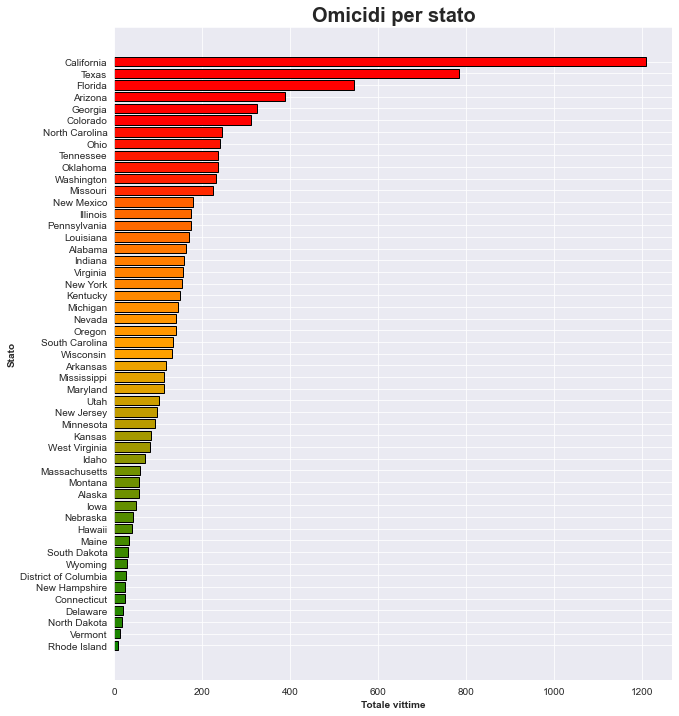

In [137]:
# definisco la scala di colori per le barre
cmap = mcolors.LinearSegmentedColormap.from_list('custom_colors', ['#008000', '#FFA500', '#FF0000'])

# creo il grafico a barre orizzontali
plt.figure(figsize=(10, 12))
plt.barh(df_state['state'], df_state['count'], color=cmap(df_state['count']), edgecolor='black')

# Inverti l'ordine delle barre
plt.gca().invert_yaxis()

# assi e titolo
plt.xlabel('Totale vittime', fontweight='bold')
plt.ylabel('Stato', fontweight='bold')
plt.title('Omicidi per stato', fontsize=20, fontweight='bold')

plt.show()

Questo grafico a barre orizzontali serve a confrontare visivamente il totale delle vittime per ogni stato. Ho impostato una gamma di 3 colori che aiutano a comprendere meglio i dati e suddividere in 3 grandi categorie visive gli stati. Non solo i colori, ma anche l'ordine degli stati aiuta a comprendere immediatamente e meglio i dati. La California è il posto dove si verifica il numero più alto di omicidi da parte della polizia, con più di 1200 vittime. Segue in classifica il Texas, poi Florida, Arizona e Georgia completano questa triste top five.

In [66]:
# creazione dataframe per stato con i numeri delle etnie
ethn = df_fatal.groupby(['state', 'race']).size().unstack().reset_index()

# unione con il dataset con conteggio totale per stato e percentuale
df_state_stats = pd.merge(df_state, ethn, on='state')

# Sostituisco i valori NaN con 0
df_state_stats.fillna(0, inplace=True)

# sposto count e percent a destra per mia comodità di lettura
df_state_stats = df_state_stats[[col for col in df_state_stats.columns if col not in ['count', 'percent']] + ['count', 'percent']]
df_state_stats

state  Asian  Black  Hispanic  Native American  Other  \
0             California   40.0  173.0     448.0              5.0    8.0   
1                  Texas    8.0  161.0     213.0              1.0    2.0   
2                Florida    2.0  163.0      68.0              0.0    4.0   
3                Arizona    0.0   32.0     115.0             16.0    0.0   
4                Georgia    3.0  127.0      19.0              0.0    0.0   
5               Colorado    5.0   25.0      67.0              5.0    0.0   
6         North Carolina    4.0   77.0      11.0              1.0    0.0   
7                   Ohio    2.0   89.0       2.0              0.0    2.0   
8              Tennessee    1.0   57.0       6.0              0.0    1.0   
9               Oklahoma    3.0   41.0      14.0             14.0    0.0   
10            Washington   13.0   29.0      28.0              7.0    0.0   
11              Missouri    1.0   70.0       6.0              0.0    0.0   
12            New Mexico    2.0    5.0      96.0              4.0    1.0   
13              Illinois    0.0   80.0      17.0              0.0    0.0   
14          Pennsylvania    2.0   57.0       9.0              0.0    0.0   
15             Louisiana    2.0   88.0       5.0              0.0    0.0   
16               Alabama    0.0   41.0       4.0              0.0    0.0   
17               Indiana    1.0   40.0       5.0              0.0    0.0   
18              Virginia    1.0   58.0       5.0              1.0    1.0   
19              New York    1.0   60.0      14.0              1.0    0.0   
20              Kentucky    1.0   23.0       3.0              1.0    0.0   
21              Michigan    1.0   45.0       3.0              1.0    1.0   
22                Nevada    2.0   22.0      37.0              1.0    0.0   
23                Oregon    0.0   10.0      12.0              1.0    0.0   
24        South Carolina    1.0   47.0       2.0              0.0    0.0   
25             Wisconsin    3.0   33.0       8.0              4.0    0.0   
26              Arkansas    2.0   31.0       0.0              0.0    0.0   
27           Mississippi    1.0   41.0       1.0              0.0    0.0   
28              Maryland    1.0   67.0       5.0              0.0    0.0   
29                  Utah    2.0    8.0      17.0              2.0    0.0   
30            New Jersey    3.0   41.0       9.0              0.0    0.0   
31             Minnesota    4.0   20.0       4.0              6.0    0.0   
32                Kansas    0.0   11.0      12.0              1.0    0.0   
33         West Virginia    1.0    8.0       0.0              0.0    0.0   
34                 Idaho    1.0    1.0       7.0              1.0    0.0   
35         Massachusetts    1.0   12.0       9.0              0.0    1.0   
36               Montana    0.0    1.0       1.0             11.0    0.0   
37                Alaska    2.0    3.0       0.0             12.0    0.0   
38                  Iowa    0.0    9.0       0.0              0.0    0.0   
39              Nebraska    0.0    6.0       4.0              1.0    0.0   
40                Hawaii   26.0    2.0       3.0              0.0    0.0   
41                 Maine    0.0    1.0       1.0              0.0    0.0   
42          South Dakota    1.0    0.0       0.0              6.0    0.0   
43               Wyoming    0.0    2.0       2.0              2.0    0.0   
44  District of Columbia    0.0   22.0       0.0              0.0    0.0   
45         New Hampshire    0.0    0.0       0.0              0.0    0.0   
46           Connecticut    0.0    5.0       7.0              0.0    0.0   
47              Delaware    0.0    7.0       1.0              0.0    0.0   
48          North Dakota    0.0    1.0       0.0              8.0    0.0   
49               Vermont    0.0    0.0       1.0              1.0    0.0   
50          Rhode Island    0.0    2.0       1.0              0.0    0.0   

    Undetermined  White  count  percent  
0          244.0  290.0 

Ho unito il mio dataframe con il conteggio per stato e la percentuale a quello appena creato con il conteggio di ogni gruppo etnico suddiviso per stato. Il risultante è questo qua sopra in cui ci sono informazioni dettagliate per ogni stato: abbiamo il numero di morti di ogni etnia, il numero di morti di cui non si sa l'etnia, il numero totale dei morti nello stato, e la percentuale rispetto al totale degli Usa. Non potendo eseguire un'analisi completa su ogni singolo stato americano, decido di concentrarmi sui primi 5 stati per numero di vittime e cercare di ricostruirne una composizione etnica, in modo da rilevare (se presenti) pattern o differenze sostanziali. Prima però ecco una mappa che mostra la distribuzione geografica degli omicidi da parte della polizia negli Usa.

In [67]:
fig = px.density_mapbox(df_fatal, lat='latitude', lon='longitude', radius=5,
                        center=dict(lat=37, lon=-95), zoom=3,
                        mapbox_style="stamen-terrain")

fig.show()

Volendo provare a fare una mappa più esaustiva e più leggibile, ho creato qua sotto anche quest'altra mappa, inserendo colorazioni e informazioni che la rendono al contempo più completa e utile di quella precedente.

In [375]:
# carico i dati geografici degli stati uniti utilizzando geopandas
us_states = gpd.read_file('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json')

# conteggio totale numero morti per stato
state_counts = df_fatal.groupby('state').size().reset_index(name='count')

# unisco dati degli stati con conteggio dei morti
merged_data = us_states.merge(state_counts, left_on='name', right_on='state', how='left')

# creo mappa centrata sulle coordinate degli Stati Uniti
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Aggiungo un layer Choropleth per visualizzare il conteggio totale dei morti per stato
folium.Choropleth(
    geo_data=merged_data,
    name='Conteggio Morti',
    data=merged_data,
    columns=['name', 'count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Conteggio totale di omicidi'
).add_to(m)

# Aggiungo il testo di popup con il conteggio totale dei morti al passaggio del mouse su uno stato
for _, row in merged_data.iterrows():
    state_name = row['name']
    state_count = row['count']
    geometry = row['geometry']
    
    # Gestisci sia i poligoni singoli che i poligoni multipli
    if isinstance(geometry, Polygon):
        centroid = geometry.centroid
    elif isinstance(geometry, MultiPolygon):
        centroid = geometry.representative_point()
    else:
        continue
    
    text = f"{state_name}<br>{state_count}"
    folium.Marker(
        location=[centroid.y, centroid.x],
        icon=folium.Icon(icon='info-sign'),
        popup=folium.Popup(text)
    ).add_to(m)

# Mostra la mappa
m



Questa mappa degli Stati Uniti risulta più completa della precedente e abbiamo molte più informazioni che possiamo leggere, anche interattivamente. Per esempio questa mappa è colorata in base ad un scala di colori dal giallo al rosso ad indicare il numero di omicidi in quello stato. Si vede immediatamente a colpo d'occhio la differenza di numero di morti tra gli stati: in più, ho inserito una sorta di 'punto informativo' al centro di ogni stato. Con un semplice click su di esso, avremmo accesso a informazioni più dettagliate come il nome dello stato, e il numero totale di morti di quello stato.

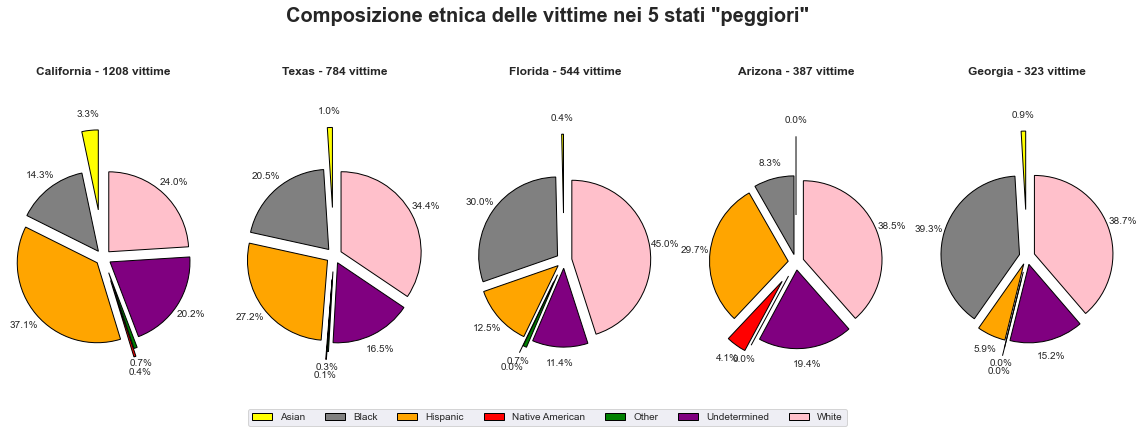

In [380]:
# Preparazione dei dati
df_top5 = df_state_stats.head(5)
states = df_top5['state']
ethnicities = df_top5.columns[1:-2]

# Definizione dei colori
colors = ['yellow', 'gray', 'orange', 'red', 'green', 'purple', 'pink']

# Definizione dei valori di esplosione
explode = [0.6, 0.1, 0.1, 0.3, 0.2, 0.1,0.1]

# Creazione del grafico a torta
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
fig.suptitle('Composizione etnica delle vittime nei 5 stati "peggiori"', fontsize=20, y=1.05,  fontweight='bold')

for i, ax in enumerate(axes):
    counts = df_top5.iloc[i, 1:-2]
    total = sum(counts)
    ax.pie(counts, colors=colors, explode=explode, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'},pctdistance=1.2)
    ax.set_title(f"{states[i]} - {int(total)} vittime", fontweight='bold')
    ax.axis('equal')

# Aggiunta della legenda
fig.legend(ethnicities, loc="center", bbox_to_anchor=(0.5, 0.1), ncol=len(ethnicities))

# Mostra il grafico
plt.show()

Questi grafici a torta aiutano a comprendere la composizione etnica degli omicidi nei 5 stati con il numero più alto di vittime. Notiamo, come già ci aspettiamo, che le etnie White, Black e Hispanic sono le più rappresentate. Occupa un certo spazio anche la fetta di Undetermined in ogni grafico, con la più grande percentuale che troviamo in California(20%). Sempre in California troviamo che la percentuale più grande è detenuta dagli Hispanic, con oltre il 37%. In California troviamo anche la più grande percentuale di Asian(3%) e più bassa di White(24%), se paragonate alle altre percentuali degli altri stati presi in analisi. Interessante da notare è anche che Native American sono sempre percentuali molto basse, intorno allo 0%, tranne che in Arizona, dove la pecentuale si assesta al 4%. In Florida quasi la metà degli omicidi della polizia hanno come vittime una persona di etnia White e Black nel 30% dei casi. In Georgia vediamo invece che la 'fetta' più grande è detenuta dai Black con quasi il 40% dei casi, che supera anche la percentuale dei White, unico caso in questo studio. 

In [381]:
# calcolo tasso di incidenza utilizzando il dataset della popolazione
df_population.head()

city state  population      lat       lng
0   Anchor Point   NaN      2057.0  59.7703 -151.7052
1      Anchorage   NaN    253421.0  61.1508 -149.1091
2         Barrow   NaN      4178.0      NaN       NaN
3       Big Lake   NaN      3136.0  61.5260 -149.9721
4  Copper Center   NaN       397.0  61.9845 -145.3544

In [124]:
# conteggio popolazione per stato
state_population = pd.DataFrame(df_population.groupby('state')['population'].sum())
state_population.head(5)

population
state                 
Alabama      2750534.0
Alaska        387478.0
Arizona      8250903.0
Arkansas     1616531.0
California  49249138.0

In [105]:
# unisco i dataframe in modo da avere tutto in uno solo
testing_df = df_state.merge(state_population, on='state')
testing_df


state  count  percent  population
0             California   1208    14.18  49249138.0
1                  Texas    784     9.20  25148150.0
2                Florida    544     6.38  21810103.0
3                Arizona    387     4.54   8250903.0
4                Georgia    323     3.79   8419735.0
5               Colorado    311     3.65   6137597.0
6         North Carolina    244     2.86   6475339.0
7                   Ohio    241     2.83   8508297.0
8              Tennessee    236     2.77   4735520.0
9               Oklahoma    236     2.77   2763420.0
10            Washington    231     2.71   7471759.0
11              Missouri    223     2.62   5369950.0
12            New Mexico    179     2.10   1493940.0
13              Illinois    174     2.04  10804913.0
14          Pennsylvania    174     2.04  10533757.0
15             Louisiana    169     1.98   3595868.0
16               Alabama    162     1.90   2750534.0
17               Indiana    158     1.85   3721040.0
18              Virginia    155     1.82   5061633.0
19              New York    153     1.80  30512911.0
20              Kentucky    150     1.76   1735527.0
21              Michigan    144     1.69   6441152.0
22                Nevada    140     1.64   3345225.0
23                Oregon    139     1.63   3808109.0
24        South Carolina    134     1.57   3012460.0
25             Wisconsin    131     1.54   3649093.0
26              Arkansas    118     1.38   1616531.0
27           Mississippi    113     1.33   1164017.0
28              Maryland    112     1.31   3516636.0
29                  Utah    102     1.20   3429680.0
30            New Jersey     97     1.14   2601111.0
31             Minnesota     93     1.09   4363323.0
32                Kansas     82     0.96   1490641.0
33         West Virginia     80     0.94    790762.0
34                 Idaho     70     0.82   1144727.0
35         Massachusetts     57     0.67   5531064.0
36               Montana     55     0.65    449445.0
37                Alaska     55     0.65    387478.0
38                  Iowa     50     0.59   1444472.0
39              Nebraska     42     0.49   1204252.0
40                Hawaii     41     0.48    944100.0
41                 Maine     34     0.40    358554.0
42          South Dakota     30     0.35    310853.0
43               Wyoming     29     0.34    242128.0
44  District of Columbia     26     0.31   5289420.0
45         New Hampshire     24     0.28    280697.0
46           Connecticut     23     0.27   2967945.0
47              Delaware     19     0.22    295004.0
48          North Dakota     18     0.21    256568.0
49               Vermont     13     0.15    145702.0
50          Rhode Island      7     0.08   1294305.0

Per calcolare il tasso di omicidi, posso dividere il numero delle vittime di ogni stato per la popolazione di quello stato e moltiplicare il risultato per una costante, ad esempio 100.000 per ottenere un tasso per 100.000 abitanti. Utilizzando quindi la seguente formula: 

tasso di omicidi = (numero di vittime / popolazione) * 100000


In [106]:
# calcolo tasso di omicidi
testing_df['kill_tax'] = (testing_df['count'] / testing_df['population']) * 100000


In [123]:
testing_df.head(10)

state  count  percent  population  kill_tax
0      California   1208    14.18  49249138.0  2.452835
1           Texas    784     9.20  25148150.0  3.117526
2         Florida    544     6.38  21810103.0  2.494257
3         Arizona    387     4.54   8250903.0  4.690396
4         Georgia    323     3.79   8419735.0  3.836225
5        Colorado    311     3.65   6137597.0  5.067130
6  North Carolina    244     2.86   6475339.0  3.768142
7            Ohio    241     2.83   8508297.0  2.832529
8       Tennessee    236     2.77   4735520.0  4.983613
9        Oklahoma    236     2.77   2763420.0  8.540142

In [110]:
# 10 stati con il kill_tax + alto
top_10_states = testing_df.nlargest(10, 'kill_tax')
top_10_states

state  count  percent  population   kill_tax
37         Alaska     55     0.65    387478.0  14.194354
36        Montana     55     0.65    449445.0  12.237315
12     New Mexico    179     2.10   1493940.0  11.981740
43        Wyoming     29     0.34    242128.0  11.977136
33  West Virginia     80     0.94    790762.0  10.116824
27    Mississippi    113     1.33   1164017.0   9.707762
42   South Dakota     30     0.35    310853.0   9.650864
41          Maine     34     0.40    358554.0   9.482533
49        Vermont     13     0.15    145702.0   8.922321
20       Kentucky    150     1.76   1735527.0   8.642908

Prendendo quindi in considerazione l'incidenza sulla popolazione, la classifica si è così ribaltata. Nel grafico vediamo che il primo posto è occupato dall'Alaska, con un tasso oltre il 14, poi abbiamo Montana, New Mexico e Wyoming con un tasso intorno al 12. Intorno al 10 troviamo il West Virginia, proseguono la classifica South Dakota, Maine, Vermont e chiude il Kentucky la top ten con un tasso di poco superiore all'8.

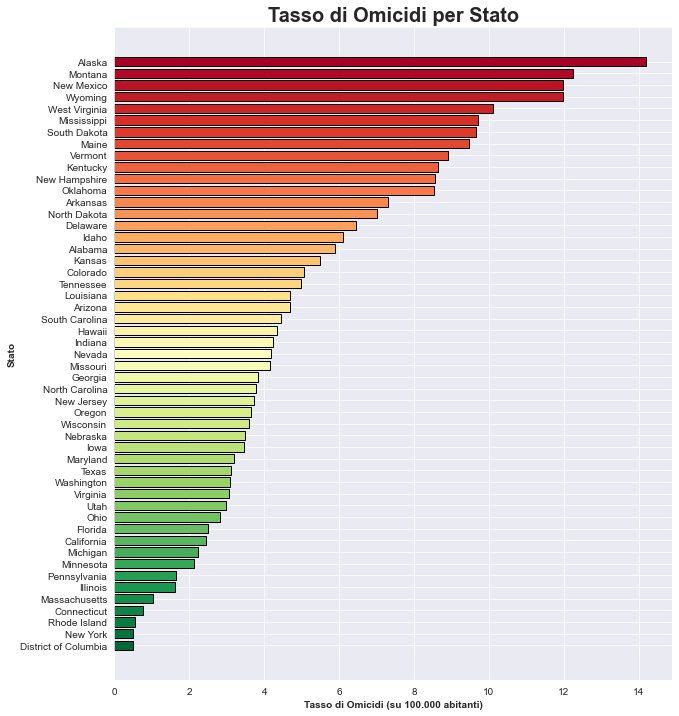

In [194]:
# Ordinamento dei dati per il tasso di omicidi in modo crescente
testing_df_sorted = testing_df.sort_values('kill_tax', ascending=True)

# Creazione di una scala di colori dalla sfumatura verde-rosso invertita
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(testing_df_sorted)))[::-1]

plt.figure(figsize=(10, 12))
plt.barh(testing_df_sorted['state'], testing_df_sorted['kill_tax'], color=colors, edgecolor='black')
plt.xlabel('Tasso di Omicidi (su 100.000 abitanti)', fontweight='bold')
plt.ylabel('Stato', fontweight='bold')
plt.title('Tasso di Omicidi per Stato', fontsize=20, fontweight='bold')
plt.show()


Prendendo in considerazione il tasso di incidenza degli omicidi sulla popolazione, che io ho calcolato su 100.000 abitanti, possiamo capire meglio i dati studiando questo grafico: Questo grafico è da confrontare con quello uguale fatto in precedenza, ma prendendo in considerazione solo il totale delle vittime per ogni stato. Ci accorgiamo così di come è profondamente modificata la classifica, e per fare un esempio su tutti, la California che detiene il record di vittime nel precedente grafico, in questo la troviamo verso il fondo della classifica, con un tasso di poco superiore al 2.

In [238]:
# Conteggio delle vittime per città
city_counts = df_fatal['city'].value_counts()

# Trova le 10 città con il numero più alto di omicidi
top_10_cities = city_counts.head(10)

# Ottenere lo stato corrispondente per ogni città
states = []
for city in top_10_cities.index:
    state = df_fatal[df_fatal['city'] == city]['state'].values[0]
    states.append(state)

# Stampa la classifica delle città con il conteggio più alto e lo stato corrispondente
print("Classifica e conteggio delle 10 città più vittime:")
for i, (city, state) in enumerate(zip(top_10_cities.index, states), 1):
    print(f"{i}. {city}, {state}: {top_10_cities[city]}")


Classifica e conteggio delle 10 città più vittime:
1. Los Angeles, California: 136
2. Phoenix, Arizona: 112
3. Houston, Texas: 98
4. San Antonio, Texas: 72
5. Las Vegas, Nevada: 72
6. Albuquerque, New Mexico: 60
7. Jacksonville, Florida: 52
8. Chicago, Illinois: 52
9. Kansas City, Kansas: 51
10. Columbus, Ohio: 49


Ho raggruppato le vittime per città, e questa è la classifica, con il conteggio puntuale degli omicidi. La città con più vittime risulta essere Los Angeles(136), seguita da Phoenix(112) e Houston(98). Solo uno stato è presente con 2 città in questa top ten, ed è il Texas, con Houston e San Antonio(72). 

In [239]:
# Creazione di una lista delle prime 10 città per numero di omicidi
top_10_cities_list = top_10_cities.index.tolist()

# Iterazione sulle prime 10 città
for city in top_10_cities_list:
    # Seleziona solo le vittime della città corrente
    city_victims = df_fatal[df_fatal['city'] == city]
    
    # Conteggio delle vittime totali nella città corrente
    total_victims = len(city_victims)
    
    # Conteggio delle vittime per razza nella città corrente
    race_counts = city_victims['race'].value_counts()
    
    # Stampa la composizione razziale delle vittime nella città corrente
    print(f"\033[31m{city}, {total_victims} vittime\033[0m")  # Stampa in rosso
    
    for race, count in race_counts.items():
        percentage = (count / total_victims) * 100
        print(f"{race}: {count} ({percentage:.2f}%)")
    print()


Los Angeles, 136 vittime
Hispanic: 71 (52.21%)
Black: 29 (21.32%)
White: 18 (13.24%)
Undetermined: 14 (10.29%)
Asian: 3 (2.21%)
Native American: 1 (0.74%)

Phoenix, 112 vittime
White: 34 (30.36%)
Hispanic: 34 (30.36%)
Undetermined: 21 (18.75%)
Black: 18 (16.07%)
Native American: 5 (4.46%)

Houston, 98 vittime
Black: 43 (43.88%)
Hispanic: 20 (20.41%)
Undetermined: 20 (20.41%)
White: 12 (12.24%)
Asian: 2 (2.04%)
Native American: 1 (1.02%)

San Antonio, 72 vittime
Hispanic: 44 (61.11%)
White: 14 (19.44%)
Black: 7 (9.72%)
Undetermined: 7 (9.72%)

Las Vegas, 72 vittime
White: 27 (37.50%)
Hispanic: 21 (29.17%)
Black: 14 (19.44%)
Undetermined: 9 (12.50%)
Asian: 1 (1.39%)

Albuquerque, 60 vittime
Hispanic: 34 (56.67%)
White: 12 (20.00%)
Undetermined: 10 (16.67%)
Black: 2 (3.33%)
Asian: 1 (1.67%)
Other: 1 (1.67%)

Jacksonville, 52 vittime
Black: 25 (48.08%)
White: 18 (34.62%)
Hispanic: 5 (9.62%)
Undetermined: 4 (7.69%)

Chicago, 52 vittime
Black: 37 (71.15%)
Hispanic: 8 (15.38%)
Undetermined: 5

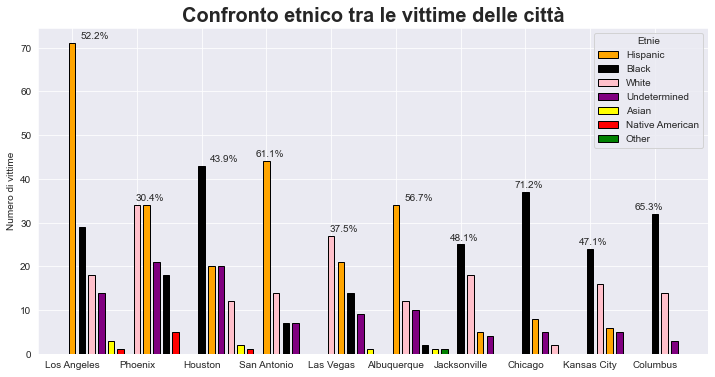

In [240]:
# Creazione delle liste per le etnie e i valori percentuali
x_labels = df_composition['Città'].tolist()

# Creazione delle barre raggruppate
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.1
spacing = 0.05
x_positions = np.arange(len(x_labels))
legend_labels = []
colors = {'Hispanic': 'orange', 'Black': 'black', 'White': 'pink', 'Undetermined': 'purple', 'Asian': 'yellow', 'Native American': 'red', 'Other': 'green'}

# Iterazione sulle città
for i, city in enumerate(x_labels):
    # Seleziona solo le vittime della città corrente
    city_victims = df_fatal[df_fatal['city'] == city]
    # Calcolo del totale delle vittime nella città corrente
    total_victims = len(city_victims)
    
    # Creazione delle barre per le etnie presenti nella città corrente
    j = 0
    highest_percentage = 0
    highest_ethnicity = ''
    
    for ethnicity, count in city_victims['race'].value_counts().items():
        percentage = (count / total_victims) * 100
        
        if percentage > highest_percentage:
            highest_percentage = percentage
            highest_ethnicity = ethnicity
        
        if ethnicity not in legend_labels:
            ax.bar(x_positions[i] + (j * (bar_width + spacing)), count, width=bar_width, color=colors[ethnicity], edgecolor='black', label=ethnicity)
            legend_labels.append(ethnicity)
        else:
            ax.bar(x_positions[i] + (j * (bar_width + spacing)), count, width=bar_width, color=colors[ethnicity], edgecolor='black')
        j += 1
    
    # Aggiunta della percentuale sulla barra più alta
    ax.text(x_positions[i] + (j * (bar_width + spacing)) - bar_width/2 - 0.5, city_victims[city_victims['race'] == highest_ethnicity].shape[0] + 1, f'{highest_percentage:.1f}%', ha='center')
    
# Etichette delle città sull'asse x
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels)

# Etichette dell'asse y e titolo del grafico
ax.set_ylabel('Numero di vittime')
ax.set_title('Confronto etnico tra le vittime delle città', fontsize=20, fontweight='bold')

# Aggiunta della legenda
ax.legend(title='Etnie')

# Mostra il grafico
plt.show()


Questo grafico a barre raggruppate esplica visivamente l'ouput precedente. Le barre sono colorate per etnia e divise per città, e per ogni città ho sottolineato la percentuale dell'etnia più colpita. Come vediamo, le etnie Black e Hispanic qua giganteggiano. Solo a Phoenix e Las Vegas c'è una percentuale maggiore di altre etnie (White). Significativo e degno di nota è la percentuale più spaventosa di questo grafico: l'etnia Black a Chicago risulta essere più del 70% dei casi complessivi. 

## Conclusione - integrazione database demografici

In [252]:
# data selection
df_income = pd.read_csv('MedianHouseholdIncome.csv', encoding='windows-1252')
df_poverty = pd.read_csv('PercentagePeopleBelowPovertyLevel.csv', encoding='windows-1252')
df_education = pd.read_csv('PercentOver25CompletedHighSchool.csv', encoding='windows-1252')
df_race = pd.read_csv('ShareRaceByCity.csv', encoding='windows-1252')

In [253]:
df_income.head()

Geographic Area             City Median Income
0              AL       Abanda CDP         11207
1              AL   Abbeville city         25615
2              AL  Adamsville city         42575
3              AL     Addison town         37083
4              AL       Akron town         21667

In [254]:
df_poverty.head()

Geographic Area             City poverty_rate
0              AL       Abanda CDP         78.8
1              AL   Abbeville city         29.1
2              AL  Adamsville city         25.5
3              AL     Addison town         30.7
4              AL       Akron town           42

In [255]:
df_education.head()

Geographic Area             City percent_completed_hs
0              AL       Abanda CDP                 21.2
1              AL   Abbeville city                 69.1
2              AL  Adamsville city                 78.9
3              AL     Addison town                 81.4
4              AL       Akron town                 68.6

In [256]:
df_race.head()

Geographic area             City share_white share_black  \
0              AL       Abanda CDP        67.2        30.2   
1              AL   Abbeville city        54.4        41.4   
2              AL  Adamsville city        52.3        44.9   
3              AL     Addison town        99.1         0.1   
4              AL       Akron town        13.2        86.5   

  share_native_american share_asian share_hispanic  
0                     0           0            1.6  
1                   0.1           1            3.1  
2                   0.5         0.3            2.3  
3                     0         0.1            0.4  
4                     0           0            0.3

In [267]:
# rinomino le colonne per maggiore facilità e chiarezza
dataframes = [df_income, df_poverty, df_education, df_race]
new_column_names = {'Geographic Area': 'state', 'Geographic area': 'state', 'City': 'city'}

for df in dataframes:
    df.rename(columns=new_column_names, inplace=True)

In [270]:
# sostituisco nomi degli stati con il loro corrispettivo esteso
for df in dataframes:
    df['state'].replace(state_mapping, inplace=True)

In [305]:
# Data Cleaning

# Sostituisco '-' con NaN nella colonna 'poverty_rate'
df_poverty['poverty_rate'] = df_poverty['poverty_rate'].replace('-', np.nan)

# Converti la colonna 'poverty_rate' in float
df_poverty['poverty_rate'] = df_poverty['poverty_rate'].astype(float)

In [318]:
# Data transformation

# creo dataframe con il tasso di povertà medio per stato
state_poverty_rate = df_poverty.groupby('state')['poverty_rate'].mean().reset_index()
state_poverty_rate.head()

state  poverty_rate
0     Alabama     20.647089
1      Alaska     19.852994
2     Arizona     25.666441
3    Arkansas     22.963216
4  California     17.124650

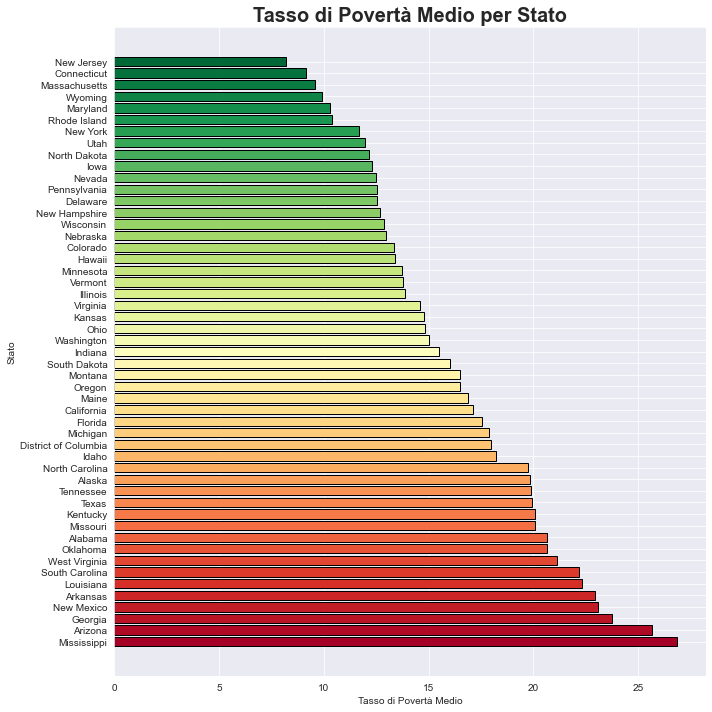

In [317]:
# Ordina i dati per tasso di povertà medio in ordine decrescente
state_poverty_rate = state_poverty_rate.sort_values('poverty_rate', ascending=False)

# Crea la scala di colori dal verde al rosso
colors = cm.RdYlGn(np.linspace(0, 1, len(state_poverty_rate)))

# Crea il grafico a barre orizzontali con colori personalizzati
plt.figure(figsize=(10, 10))
bars = plt.barh(state_poverty_rate['state'], state_poverty_rate['poverty_rate'], color=colors, edgecolor='black')

# Imposta i bordi delle barre come neri
for bar in bars:
    bar.set_edgecolor('black')

plt.xlabel('Tasso di Povertà Medio')
plt.ylabel('Stato')
plt.title('Tasso di Povertà Medio per Stato', fontsize=20, fontweight='bold')
plt.tight_layout()

# Mostra il grafico
plt.show()

In [325]:
# df_income

# Replace non-numeric values with NaN
df_income['Median Income'] = pd.to_numeric(df_income['Median Income'], errors='coerce')

# Calculate the median income per state
state_median_income = df_income.groupby('state')['Median Income'].mean().reset_index()
state_median_income.head()

state  Median Income
0     Alabama   40577.309524
1      Alaska   52099.594406
2     Arizona   42495.666667
3    Arkansas   35593.408915
4  California   62097.352113

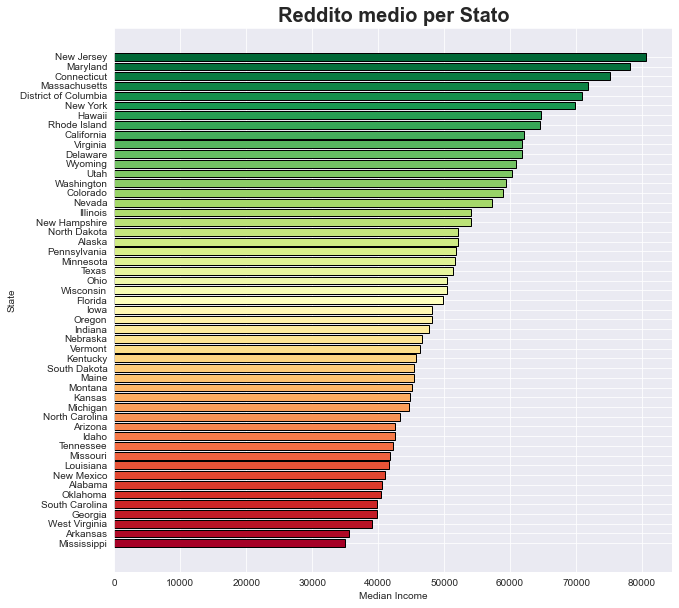

In [337]:
# Ordiniamo il dataframe per valore di "Median Income"
df_income_sorted = state_median_income.sort_values('Median Income')

# Creiamo una scala di colori che va dal verde al rosso
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(df_income_sorted)))

# Creiamo il grafico a barre orizzontali
plt.figure(figsize=(10, 10))
plt.barh(df_income_sorted['state'], df_income_sorted['Median Income'], color=colors, edgecolor='black')

# Aggiungiamo le etichette e i titoli
plt.xlabel('Median Income')
plt.ylabel('State')
plt.title('Reddito medio per Stato', fontsize=20, fontweight='bold')

# Mostrare il grafico
plt.show()

In [335]:
# df_education
df_education['percent_completed_hs'] = pd.to_numeric(df_education['percent_completed_hs'], errors='coerce')
df_education_state = df_education.groupby('state')['percent_completed_hs'].mean().reset_index()
df_education_state.head()

state  percent_completed_hs
0     Alabama             80.300685
1      Alaska             84.627381
2     Arizona             80.467117
3    Arkansas             79.949538
4  California             81.955430

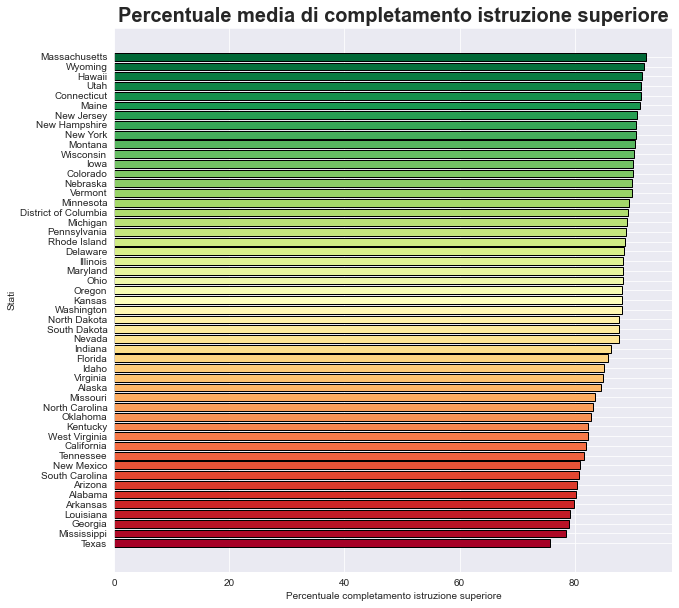

In [345]:
# Ordinamento dei dati per percentuale completamento istruzione superiore in modo decrescente
df_education_state = df_education_state.sort_values('percent_completed_hs', ascending=True)

# Creazione dei colori per le barre
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(df_education_state)))

# Creazione del grafico a barre orizzontali
plt.figure(figsize=(10, 10))
plt.barh(df_education_state['state'], df_education_state['percent_completed_hs'], color=colors, edgecolor='black')

# Aggiunta di etichette
plt.xlabel('Percentuale completamento istruzione superiore')
plt.ylabel('Stati')

# Aggiunta di un titolo
plt.title('Percentuale media di completamento istruzione superiore', fontsize=20, fontweight='bold')

# Visualizzazione del grafico
plt.show()

In [362]:
# unisco i dataframe
df_demos = df_education_state.merge(state_median_income, on='state').merge(state_poverty_rate, on='state')

In [361]:
df_demos.head()

state  percent_completed_hs  Median Income  poverty_rate
0        Texas             75.690000   51335.326411     19.918070
1  Mississippi             78.470718   35002.099125     26.884254
2      Georgia             79.012500   39781.803954     23.777404
3    Louisiana             79.289641   41635.905702     22.338901
4     Arkansas             79.949538   35593.408915     22.963216

In [360]:
# unisco anche il precedente dataframe con il conteggio per stato
df_combined = df_demos.merge(df_state, on='state')

In [359]:
# visualizzo dataframe
df_combined

state  percent_completed_hs  Median Income  poverty_rate  \
0                  Texas             75.690000   51335.326411     19.918070   
1            Mississippi             78.470718   35002.099125     26.884254   
2                Georgia             79.012500   39781.803954     23.777404   
3              Louisiana             79.289641   41635.905702     22.338901   
4               Arkansas             79.949538   35593.408915     22.963216   
5                Alabama             80.300685   40577.309524     20.647089   
6                Arizona             80.467117   42495.666667     25.666441   
7         South Carolina             80.849873   39787.092838     22.161519   
8             New Mexico             80.982639   40952.905363     23.080787   
9              Tennessee             81.631163   42249.774882     19.887209   
10            California             81.955430   62097.352113     17.124650   
11         West Virginia             82.345050   39097.117318     21.134406   
12              Kentucky             82.370130   45683.308151     20.080000   
13              Oklahoma             82.909743   40447.293003     20.657104   
14        North Carolina             83.249458   43302.337589     19.747290   
15              Missouri             83.522266   41747.616016     20.105859   
16                Alaska             84.627381   52099.594406     19.852994   
17              Virginia             84.880270   61867.679348     14.585835   
18                 Idaho             85.168000   42484.789720     18.236889   
19               Florida             85.737814   49811.306215     17.566011   
20               Indiana             86.319265   47713.010786     15.499853   
21                Nevada             87.715385   57322.970588     12.466154   
22          South Dakota             87.753906   45408.261128     16.032292   
23          North Dakota             87.815250   52141.705882     12.162250   
24            Washington             88.197577   59315.282230     15.017609   
25                Kansas             88.230448   44838.943574     14.762985   
26                Oregon             88.304545   48088.066474     16.523467   
27                  Ohio             88.344600   50457.210931     14.851113   
28              Maryland             88.422481   78126.496746     10.312209   
29              Illinois             88.483443   54052.706144     13.879780   
30              Delaware             88.519481   61792.407895     12.555844   
31          Rhode Island             88.825000   64537.542857     10.369444   
32          Pennsylvania             89.023396   51758.766157     12.515586   
33              Michigan             89.207659   44685.505848     17.900723   
34  District of Columbia             89.300000   70848.000000     18.000000   
35             Minnesota             89.465559   51678.658343     13.745736   
36               Vermont             89.976860   46284.777778     13.785950   
37              Nebraska             89.987868   46582.907407     12.984575   
38              Colorado             90.106637   58857.697044     13.362832   
39                  Iowa             90.112263   48116.048604     12.292522   
40             Wisconsin             90.263964   50411.400778     12.858687   
41               Montana             90.488430   45119.981191     16.513774   
42              New York             90.613724   69890.671514     11.668231   
43         New Hampshire             90.711340   54026.318681     12.659794   
44            New Jersey             90.853959   80584.406367      8.190976   
45                 Maine             91.430769   45397.472868     16.893846   
46           Connecticut             91.591667   75149.652482      9.137500   
47                  Utah             91.617925   60216.368771     11.982704   
48                Hawaii             91.665563   64708.744966     13.400662   
49               Wyoming             92.100538   60874.993464      9.

In [352]:
# esploro le correlazioni
correlation_matrix = df_combined[['percent_completed_hs', 'Median Income', 'poverty_rate', 'count']].corr()
correlation_matrix


percent_completed_hs  Median Income  poverty_rate  \
percent_completed_hs              1.000000       0.600763     -0.861672   
Median Income                     0.600763       1.000000     -0.771035   
poverty_rate                     -0.861672      -0.771035      1.000000   
count                            -0.482495      -0.048572      0.290027   

                         count  
percent_completed_hs -0.482495  
Median Income        -0.048572  
poverty_rate          0.290027  
count                 1.000000

Il risultato è una matrice di correlazione che mostra le correlazioni tra le variabili selezionate. La correlazione può variare da -1 a 1, dove -1 indica una correlazione negativa, 1 indica una correlazione positiva e 0 indica nessuna correlazione.

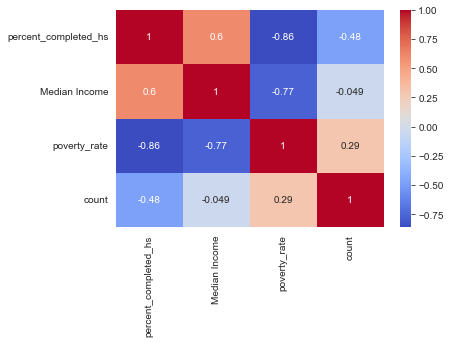

In [353]:
# heatmap per rappresentazione visiva
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

L'heatmap mostra i valori di correlazione e utilizza una scala di colori che va dal blu(correlazione negativa) al rosso (correlazione positiva). Sembra quindi esserci una correlazione positiva tra reddito medio e percentuale di completamento degli studi, e anche una leggera correlazione positiva tra il numero totale di morti e il tasso di povertà.

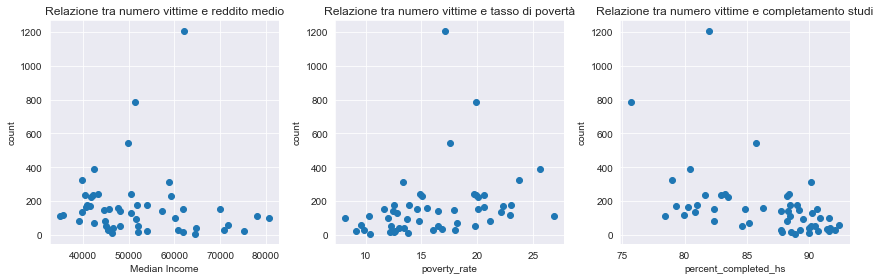

In [358]:
# Creazione dei subplots per gli scatter plots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Scatter plot per la relazione tra count e Median Income
axes[0].scatter(df_combined['Median Income'], df_combined['count'])
axes[0].set_xlabel('Median Income')
axes[0].set_ylabel('count')
axes[0].set_title('Relazione tra numero vittime e reddito medio')

# Scatter plot per la relazione tra count e poverty_rate
axes[1].scatter(df_combined['poverty_rate'], df_combined['count'])
axes[1].set_xlabel('poverty_rate')
axes[1].set_ylabel('count')
axes[1].set_title('Relazione tra numero vittime e tasso di povertà')

# Scatter plot per la relazione tra count e percent_completed_hs
axes[2].scatter(df_combined['percent_completed_hs'], df_combined['count'])
axes[2].set_xlabel('percent_completed_hs')
axes[2].set_ylabel('count')
axes[2].set_title('Relazione tra numero vittime e completamento studi')

# Imposta lo spaziamento tra i subplots
plt.tight_layout()

# Mostra i grafici
plt.show()

Come ultimo grafico, questo scatterplot esplora la relazione tra il numero delle vittime e le altre variabili del dataframe.

## Conclusioni:

In conclusione, attraverso l'esplorazione del dataset del Washington Post, abbiamo raggiunto gli obiettivi prefissati e ottenuto risultati su diversi fronti.

Sotto l'aspetto temporale/cronologico, abbiamo analizzato la distribuzione temporale degli omicidi. Questa analisi ha fornito un quadro complessivo degli omicidi commessi dalla polizia negli anni presi in considerazione.

Dal punto di vista etnico/demografico, abbiamo esaminato le differenze etniche, di età e di genere nelle vittime di sparatorie mortali. Questa analisi ha contribuito a comprendere la complessità delle dinamiche sociali e demografiche legate agli omicidi.

Sul fronte geografico/spaziale, abbiamo identificato le aree geografiche negli Stati Uniti con il maggior numero di omicidi e abbiamo studiato la distribuzione etnica delle vittime. Questa analisi ci ha permesso di ottenere una visione dettagliata delle differenze geografiche nella violenza armata da parte della polizia.

Calcolando l'incidenza degli omicidi sulla popolazione utilizzando il dataset della popolazione delle città americane, siamo stati in grado di valutare l'entità dell'impatto di questi eventi sulla società.

Infine, abbiamo integrato le analisi con i dataset socio-economici delle città americane, esplorando le associazioni tra reddito medio, tasso di povertà e percentuale di istruzione nel contesto degli omicidi. Questo ci ha permesso di considerare le variabili socio-economiche come possibili fattori influenti nella comprensione del fenomeno degli omicidi commessi dalla polizia.

Complessivamente, le conclusioni tratte da queste analisi possono contribuire a informare le politiche di sicurezza pubblica e le iniziative di prevenzione della violenza, cercando di affrontare le disuguaglianze e promuovere una maggiore equità nella società.